# Inverting leaf reflectance & transmittance using PROSPECT

The PROSPECT-D model (Féret et al 2017) enjoys a wide use by the community. It's a simple model that is able to produce realistic predictions of leaf reflectance and transmittance spectra. In this practical, we will try to invert the PROSPECT model to match observations of leaf reflectance and/or transmittance.

## Inversion approach

### Maximum Likelihood

In this case, we will maximise the likelihood of the data

$$
J_{obs}(\vec{x})=\left[H(\vec{x} - \left(\vec{\rho},\vec{\tau}\right) \right]^{\top}\mathbf{C}_{obs}^{-1}\left[H(\vec{x} - \left(\vec{\rho},\vec{\tau}\right) \right]
$$

$H(\vec{x})$ is the prediction of reflectance or transmittance from the PROSPECT model parameterised by vector $\vec{x}$. $\mathbf{C}_{obs}$ is the covariance matrix of the uncertainty, in essence the observational noise. The task here is to minimise $J(\vec{x})$, and the minimum is the smallest distance between predictions and observations (modulated by the amplitude).

### Bayesian inversion

In this case, we will add an **a priori distribution**. To simplify things, we will assume that the prior is a Gaussian, with a mean vector $\vec{\mu}$ and a prior covariance matrix given by $\mathbf{C}_{p}$. The Bayesian approach combines the evidence with the prior to produce an **a posteriori distribution**. 

It is important to note that the pdf here is an indication of our uncertainty.

We will use two options to solve the problem: MCMC and a variational method. The former is numerically expensive, but provides a very accurate description of the posterior shape, whereas the latter is fast, but makes assumptions on the nature of the posterior 

## Reflectance, transmittance, both?

We will look at the effectiveness of using $\rho$, $\tau$ or both in the inversion.



## The data

When you have a model, you can cook up a dataset: you can just run the model forward for a known *state vector*, and then maybe add some noise to it. This is useful, because you have full understanding of the system. We can use the `fwd_model` function with a vector `x`, as well as the uncertainty for the "measurements". The vector has the following order

1. N layers parameter
2. Leaf chlorophyll concentration
3. Leaf carotenoid concentration
4. Senescent leaf fraction
5. Equivalent water thickness
6. Leaf dry matter
7. Anthocyanins



We will first used a canned dataset of reflectance and transmittance, but you can also upload your spectra. The data have been taken from the [LOPEX'93 database](http://ies-webarchive-ext.jrc.it/ies/data-portals.html#dp28). You can read out the leaf constituents estimated in the lab to check how well your model inversions worked. Note that this isn't a fair test: LOPEX was used to develop the absorption spectra and so on in PROSPECT-D, so it ought to work reasonably well with this dataset!

We can use the `read_lopex_sample` function to read samples. It returns mean reflectances and transmittances, as well as associted uncertainties, and plots these.




In [1]:
from prospect_experiments import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook




<IPython.core.display.Javascript object>


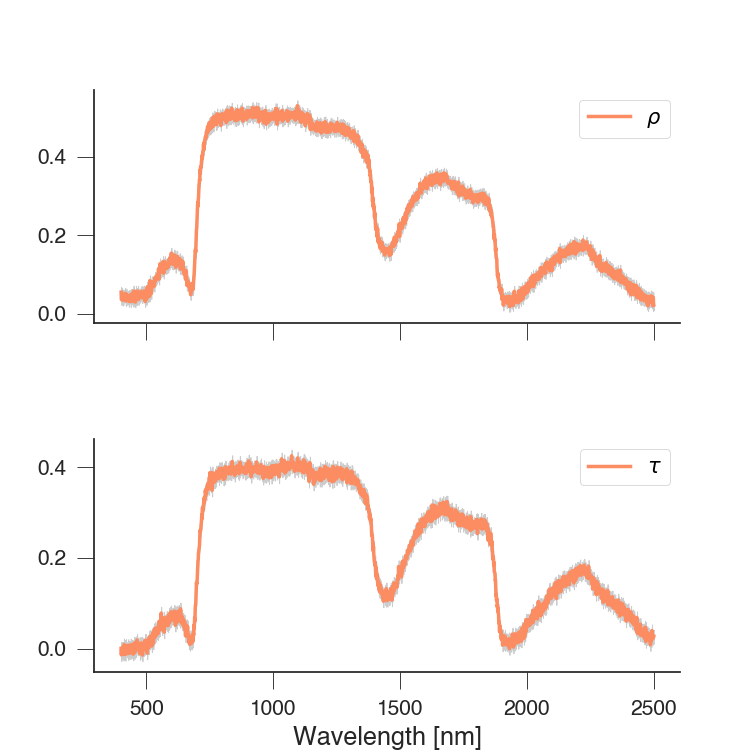

In [5]:
#Create data using model
x_truth=np.array([2., 20., 10., 0.2, 0.015, 0.009, 8.])
rho_meas, tau_meas = fwd_model (x_truth, np.ones(2101)*0.007, np.ones(2101)*0.007)



<IPython.core.display.Javascript object>


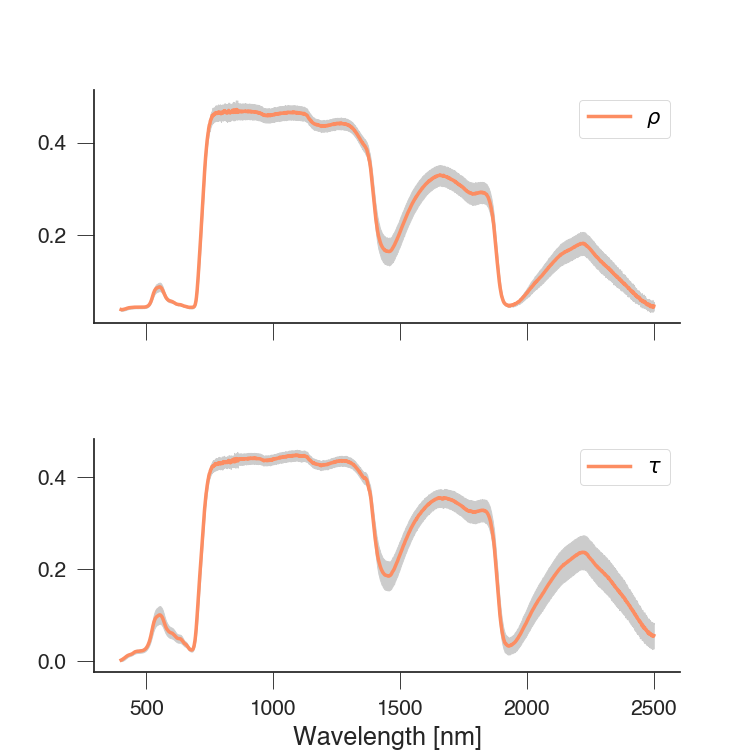

In [2]:
# Load data from LOPEX'93
# Doing sample 15

rho, rho_unc, tau, tau_unc = read_lopex_sampe(15, do_plot=True)

## ML inversion

The next snippet performs a ML inversion. It only takes into account the goodness of fit modulated by the uncertainties in the measurements. You need to provide a starting point for the inversion in parameter space, which is hopefully close to the solution. It also plots the input spectra as well as the reconstructed spectra, as well as the parameters that have resulted from the inversion.

### Robustness

The first thing is to check how reliable is the solution based on different starting points. Try a few of these, and satisfy yourself that the inversion results in stable parameters.

### Reflectance

We can use only reflectance for the inversion. You can invert the data with the `do_trans=False` option and it will ignore the transmittance.

### Reflectance & transmittance

To invert the model using both reflectance and transmittance, set `do_trans` to `True`. Compare the results with the reflectance only inversions



<IPython.core.display.Javascript object>


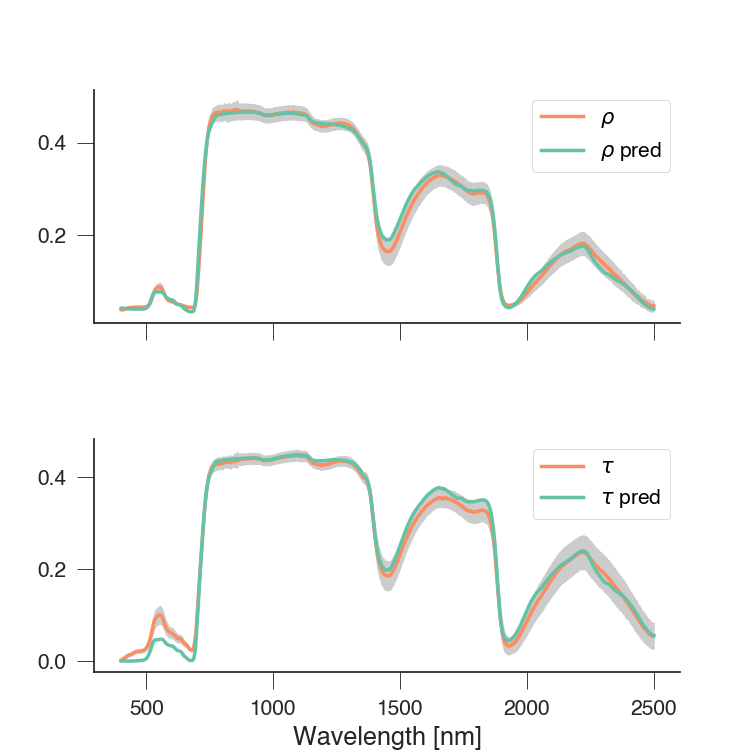

      fun: 3153.2405471715606
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.58432920e-01,   6.50288712e-03,  -5.45696821e-04,
        -4.27462510e-02,  -1.70034582e+00,   6.86300154e+00,
        -1.86446414e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 984
      nit: 105
   status: 0
  success: True
        x: array([  1.67842443e+00,   5.25459028e+01,   9.73339378e+00,
         1.01979385e-01,   9.34263398e-03,   9.49902851e-03,
         6.00733679e+00])


In [3]:
# The starting point
x0=np.array([2., 20., 10., 0.2, 0.015, 0.009, 8.])
retval = max_lklhood(x0, rho, rho_unc, tau, tau_unc, do_trans=False)
print retval

## Bayesian inversion

In the Bayesian inversion, we supplement the likelihood with a prior parameter distribution. This adds an extra constraint. In this case, we assume we have a prior pdf for the parameters that is a multivariate Gaussian, controlled by a mean vector and an inverse covariance function. So the vector is a 7-element vector and the matrix is 7x7. In this case we also calculate the full posterior uncertainty, which we show as a correlation matrix.

The following is an example with the LOPEX data. We set a prior mean vector, and then we set up a diagonal inverse prior covariance matrix. We then just call the function `variational_prospect`. As before, you can switch the use of transmittance data for the inversion by using the `do_trans` flag.

<IPython.core.display.Javascript object>


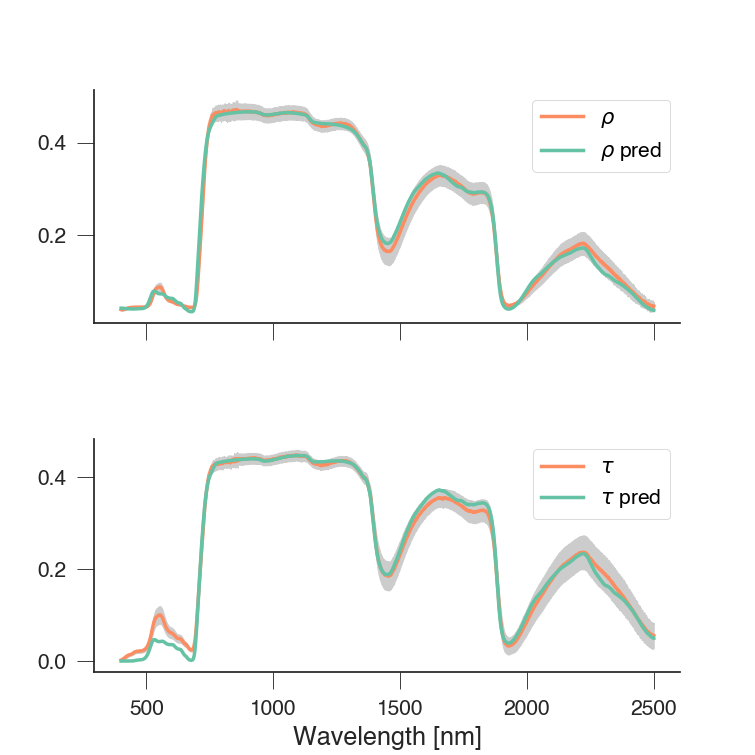

<IPython.core.display.Javascript object>


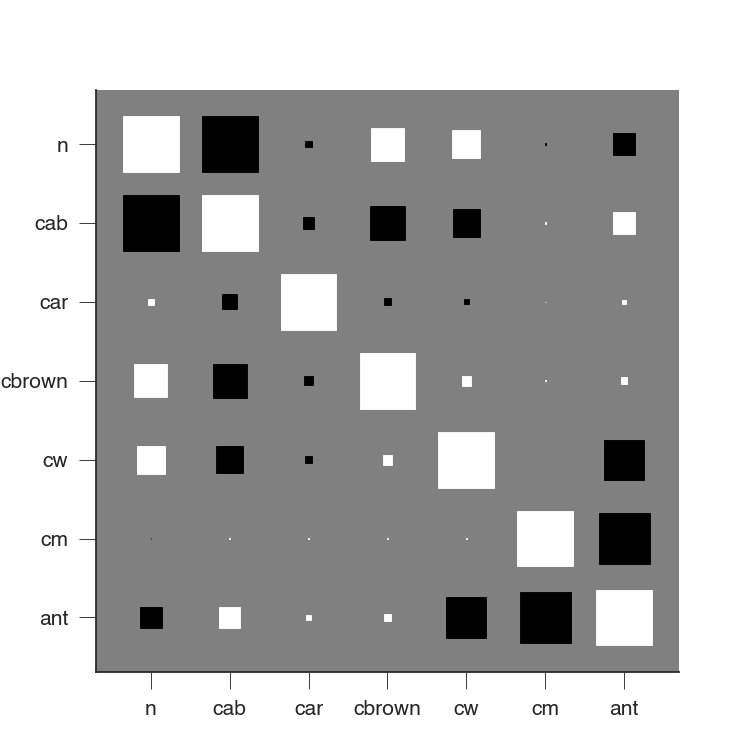

2.0
 Parameter	|	      Posterior Mean	|	  Posterior Variance
         N	|	                1.69	|	              0.1625

       Cab	|	               47.69	|	              0.1645

       Car	|	                5.00	|	              0.0099

    Cbrown	|	                0.13	|	              0.0047

        Cw	|	                0.01	|	              0.0001

        Cm	|	                0.01	|	              0.0001

       Ant	|	                7.70	|	              0.0001



In [6]:
mu_prior = np.array([2.2, 40., 5., 0.1, 0.015, 0.009, 8])
cov = np.array([2.1, 10., 0.01, 0.01, 0.0001, 0.0001, 1.])
inv_cov = np.diag(1./cov**2)
retval = variational_prospect(mu_prior, inv_cov, rho, rho_unc, tau, tau_unc)

## Some Bayesian exercises

### Things to look out for

* Typically your eyes will be attracted to the posterior mean, but don't forget the uncertainty: consider how much it has shrunk with respect to the prior
* Check out the correlations between parameters. Can you reconcile them with what you know about the spectral sensitivity of the different components?
* Can you figure out how to propagate the parameter uncertainty into PROSPECT so that you can forward model the inveted parameters uncertainty to reflectance & transmittance

### Try different priors

By putting very small uncertainties in the prior parameters, you can effectively "fix" parameters. Do this to explore the information you can set or retrieve. Be particularly observant of the uncertainty plots and ranges!

You might want to peruse the LOPEX database of lab measurements to inform your choice of priors. But you may also want to use an **uninformative prior** (wide uncertainties).

### Reflectance, transmittance or both?

As before, but now think about your prior distribution and how that affects things.

### Impose correlations in the priors

There's evidence that leaf chlorophyll is correlated with carotenoid concentration. You can try to impose that correlation in the prior covariance matrix, and see the effect.

### Compare with ML solution

Well, is it any better? Can you test robustness of the inversions? 